In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

df = pd.read_excel("dataset/Energy_Power_Weather.xlsx", sheet_name=0)
df.head()

,Timestamp,kilowatt-hours,Date,TempMin,TempMax,Weather
0,2019-01-28,2.165,2019-01-28,18,23,Patchy rain possible
1,2019-01-29,6.470,2019-01-29,20,25,Patchy rain possible
2,2019-01-30,9.157,2019-01-30,21,24,Patchy rain possible
3,2019-01-31,16.269,2019-01-31,21,25,Sunny
4,2019-02-01,8.447,2019-02-01,19,23,Moderate rain at times


# 1. Khai phá dữ liệu

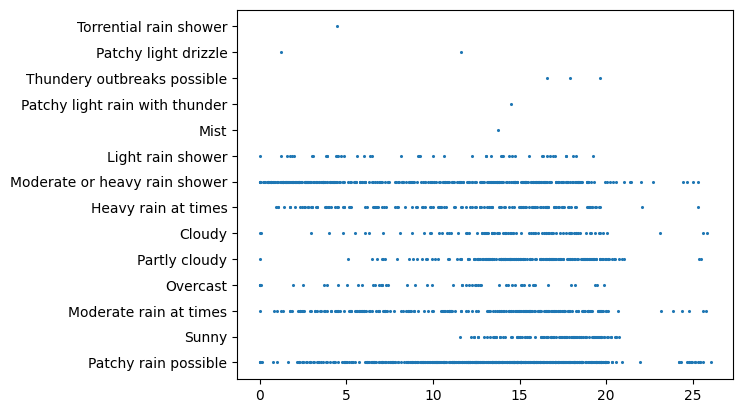

In [12]:
plt.scatter(df["kilowatt-hours"], df["Weather"], s=1.5)
plt.show()

In [1]:
from sklearn.decomposition import PCA

# Giả sử X là dữ liệu của bạn, có nhiều hơn 2 chiều
X = np.random.rand(100, 5)

# Khởi tạo PCA với 2 thành phần chính
pca = PCA(n_components=2)

# Fit PCA vào dữ liệu
pca.fit(X)

# Chuyển đổi dữ liệu sang 2 chiều
X_pca = pca.transform(X)

print("Dữ liệu sau khi giảm chiều:\n", X_pca)

Dữ liệu sau khi giảm chiều:
 [[-0.19970984 -0.26147524]
 [-0.35314769 -0.33207924]
 [-0.36635001  0.35644528]
 [-0.30998036 -0.09828525]
 [ 0.23190947 -0.12309406]
 [-0.12535946  0.36976213]
 [ 0.27662571 -0.49084479]
 [ 0.65246691 -0.09165428]
 [ 0.32370848  0.01582217]
 [-0.03355935 -0.18188822]
 [ 0.19612239  0.19663572]
 [ 0.76352906 -0.35073129]
 [ 0.12847984  0.38811736]
 [-0.31437916  0.49562787]
 [-0.16248023 -0.17373923]
 [-0.5736688  -0.0195838 ]
 [ 0.33011028 -0.60558609]
 [ 0.0733766   0.42909421]
 [-0.65886402 -0.02187035]
 [-0.06406307  0.29588779]
 [ 0.47114894  0.45370843]
 [-0.31614101 -0.4776384 ]
 [ 0.22661845 -0.27295366]
 [-0.46536802  0.35108626]
 [ 0.22549953 -0.14832438]
 [ 0.0757869  -0.21592328]
 [ 0.34490772  0.01598883]
 [-0.4641973  -0.18965118]
 [-0.67318622  0.35771087]
 [-0.09146179  0.07814039]
 [-0.00365463  0.26361075]
 [-0.12302927 -0.08257729]
 [-0.13997815 -0.06603295]
 [ 0.59650228 -0.14536673]
 [-0.16648684 -0.48342222]
 [-0.11924771  0.24227215]